# Generation and post-analysis in aids dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import data_processing, visualization

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Original data loading, analysis and visualization

### 1.1. Experiment setting - links to data

In [2]:
dataset_name = "Aids"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### 1.2. Loading, feature analysis, and visualization of original data: control vs treated group

In [3]:
aids_control_fnames = ['time', 'censor'] + pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
aids_control = pd.read_csv(data_file_control, header=None, names=aids_control_fnames)
print(aids_control.head())

   time  censor  strat2  sex  raceth  ivdrug  karnof    cd4  priorzdv  age
0   189       0       1    1       1       0     100  169.0      39.0   34
1   287       0       1    2       2       0      90  149.5      15.0   34
2   199       0       1    1       1       0      90   46.0      53.0   48
3   270       0       1    1       2       0     100   54.5       6.0   51
4   276       0       1    1       1       0     100   95.0       7.0   34


In [4]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [5]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=aids_control_fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=aids_control_fnames)

# Update dataframe
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [6]:
from execute import surv_hivae, surv_gan, surv_vae
generators_dict = {"HI-VAE" : surv_hivae, 
                   "Surv-GAN" : surv_gan, 
                   "Surv-VAE" : surv_vae}

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [7]:
# the datasets used for training is data_init_control
n_generated_sample = 100

generators_sel = ["HI-VAE", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    if generator_name in ["HI-VAE"]:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control_encoded, miss_mask_control, true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_sample)
    else:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control, columns=aids_control_fnames, target_column="censor", time_to_event_column="time", n_generated_sample=n_generated_sample)

Generate data by HI-VAE
Epoch: [ 0]  time: 0.1190, ELBO_train: -21.73045197, KL_z: 1.34531965, KL_s: 0.07231607, reconstruction loss: -20.31281624
Epoch: [100]  time: 3.5392, ELBO_train: -17.58477974, KL_z: 0.61346816, KL_s: 0.03842216, reconstruction loss: -16.93288943
Epoch: [200]  time: 6.7142, ELBO_train: -17.35018730, KL_z: 0.80700449, KL_s: 0.03623362, reconstruction loss: -16.50694920
Epoch: [300]  time: 10.1906, ELBO_train: -17.46599007, KL_z: 0.89201964, KL_s: 0.03480258, reconstruction loss: -16.53916785
Epoch: [400]  time: 14.3897, ELBO_train: -17.27484894, KL_z: 0.98273066, KL_s: 0.03629823, reconstruction loss: -16.25582005
Training finished.
Generate data by Surv-GAN


[2025-04-29T17:39:32.603952+0200][5787][CRITICAL] load failed: Failed to import transformers.trainer because of the following error (look up to see its traceback):
Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.
[2025-04-29T17:39:32.604799+0200][5787][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2025-04-29T17:39:32.605116+0200][5787][CRITICAL] module plugin_great load failed
[2025-04-29T17:39:32.613977+0200][5787][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[202

Generate data by Surv-VAE


 65%|██████▌   | 650/1000 [02:05<01:07,  5.19it/s]


In [8]:
# Convert generated data into dataframe
df_gen_control_dict = {}
for generator_name in generators_sel:
    list_df_gen_control = []
    for j in range(n_generated_sample):
        df_gen_control_j = pd.DataFrame(data_gen_control_dict[generator_name][j].numpy(), columns=aids_control_fnames)
        df_gen_control_j['treatment'] = 0
        list_df_gen_control.append(df_gen_control_j)
        
    df_gen_control_dict[generator_name] = list_df_gen_control

### 3. Compare generation performance

In [9]:
from utils.metrics import general_metrics
scores = []
for generator_name in generators_sel:
    scores.append(general_metrics(df_init_control, df_gen_control_dict[generator_name], generator_name))
scores_df = pd.concat(scores)

#### 3.1. Data resemblance

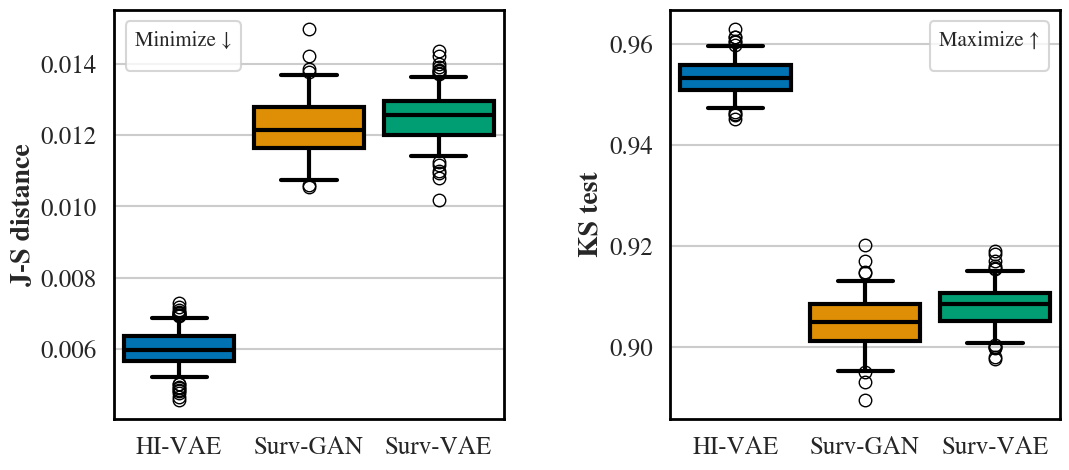

In [10]:
from utils.visualization import visualize_perf
visualize_perf(scores_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

#### 3.2 Utility

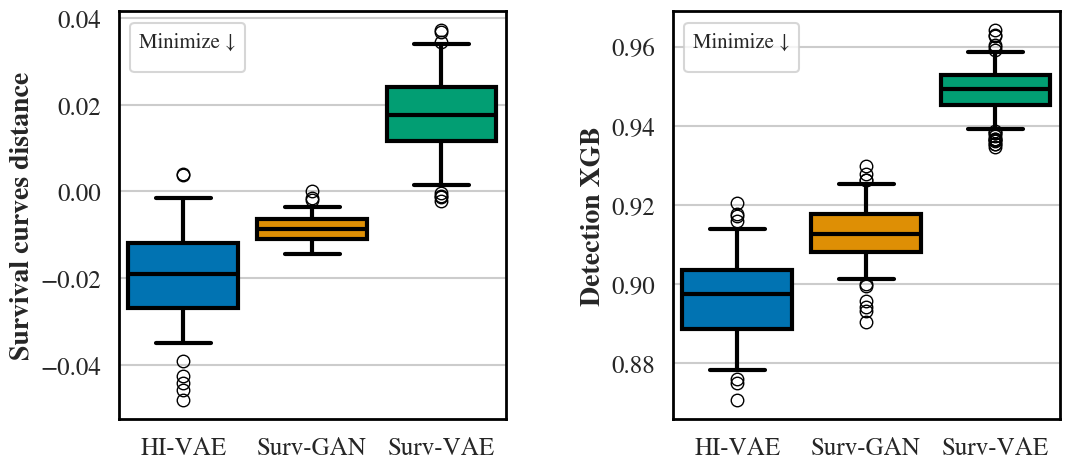

In [11]:
visualize_perf(scores_df, metrics=[['Survival curves distance', "min"], ['Detection XGB', "min"]])

#### 3.3 Privacy

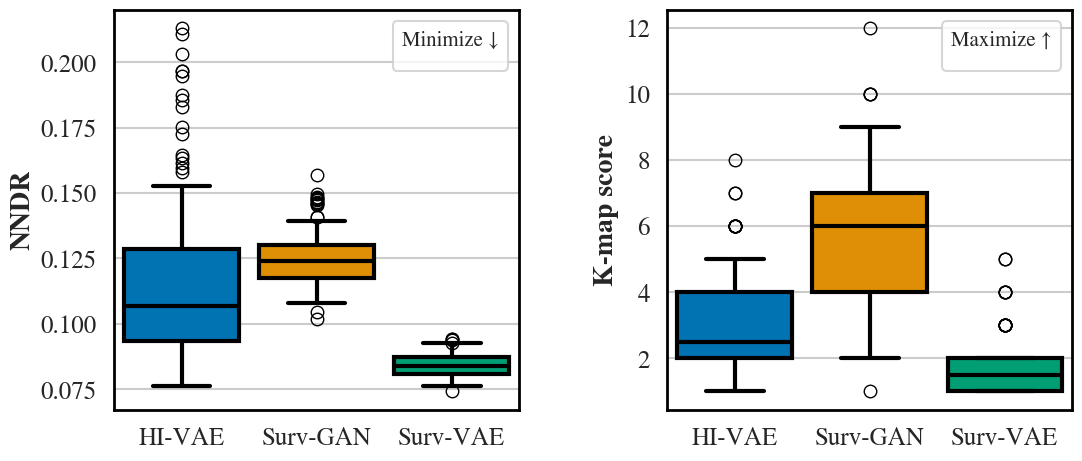

In [12]:
visualize_perf(scores_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])